In [2]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Embedding, TimeDistributed, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [3]:
loaded_piano_rolls = np.load('input-data/piano_rolls/classical/piano_rolls.npy', allow_pickle=True)

In [4]:
for matrix in loaded_piano_rolls:
    if np.isnan(matrix).any():
        print("Матрица содержит NaN")

In [6]:
sequence_length = int(loaded_piano_rolls[0].shape[0])
num_features = int(loaded_piano_rolls[0].shape[1])
print(sequence_length, num_features)

3000 128


## Модель LSTM Autoencoder

Здесь будет VAE

 ![](https://magenta.tensorflow.org/assets/music_vae/nsynth-ae.png)
 
 




In [ ]:
# from keras.layers import Input, Dense, Lambda, Flatten, Reshape
# from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
# from keras.models import Model
# from keras import backend as K
# from keras import metrics
# from keras.datasets import mnist
# import numpy as np

# # Задаем размерность входных данных
# input_shape = (128, 128, 1)

# # Функция для сэмплирования из нормального распределения
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=K.shape(z_mean))
#     return z_mean + K.exp(z_log_var / 2) * epsilon

# # Задаем архитектуру энкодера
# inputs = Input(shape=input_shape, name='encoder_input')
# x = inputs
# x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Flatten()(x)
# z_mean = Dense(64, name='z_mean')(x)
# z_log_var = Dense(64, name='z_log_var')(x)

# # Сэмплируем из нормального распределения
# z = Lambda(sampling, name='z')([z_mean, z_log_var])

# # Задаем архитектуру декодера
# latent_inputs = Input(shape=(64,), name='z_sampling')
# x = latent_inputs
# x = Dense(16 * 16 * 128, activation='relu')(x)
# x = Reshape((16, 16, 128))(x)
# x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

# # Определяем модель
# encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# decoder = Model(latent_inputs, outputs, name='decoder')
# outputs = decoder(encoder(inputs)[2])
# vae = Model(inputs, outputs, name='vae')

# # Определяем функцию потерь
# reconstruction_loss = metrics.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= 128 * 128
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

# vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae.add_loss(vae_loss)
# vae.compile(optimizer='adam')

# # vae.load_weights("weights/classical/weights-198-106.2944-bigger.hdf5")


# x_train = loaded_piano_rolls

# filepath = "weights/classical/weights-{epoch:02d}-{loss:.4f}-bigger.hdf5"

# checkpoint = ModelCheckpoint(
#         filepath,
#         monitor='loss',
#         verbose=0,
#         save_best_only=True,
#         mode='min'
# )

# callbacks_list = [checkpoint]

# vae.fit(x_train, x_train,
# epochs=200,
# batch_size=128,
# callbacks=callbacks_list)

In [86]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Размерность скрытого пространства
latent_dim = 128

# Энкодер
encoder_inputs = keras.Input(shape=(1000, 128))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Сэмплирование из распределения Гаусса
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# Декодер
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(1000 * 128, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((1000, 128))(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


# VAE модель
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")


# Функция потерь
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= 1000 * 128
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss) * -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Компиляция модели
vae.compile(optimizer=keras.optimizers.Adam())


# vae.load_weights("weights/classical/weights-208-84.9162-bigger.hdf5")

x_train = np.array(loaded_piano_rolls[0:10])

filepath = "weights/classical/weights-{epoch:02d}-{loss:.4f}-bigger.hdf5"

checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
)

callbacks_list = [checkpoint]


# Обучение модели
vae.fit(x_train, epochs=100, batch_size=128, callbacks=callbacks_list) 
# Работает

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 1000, 128)]  0           []                               
                                                                                                  
 flatten_8 (Flatten)            (None, 128000)       0           ['input_58[0][0]']               
                                                                                                  
 dense_69 (Dense)               (None, 512)          65536512    ['flatten_8[0][0]']              
                                                                                                  
 dense_70 (Dense)               (None, 256)          131328      ['dense_69[0][0]']               
                                                                                            

KeyboardInterrupt: 

In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Размерность скрытого пространства
latent_dim = 128

# Энкодер
encoder_inputs = keras.Input(shape=(1000, 128))
x = layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = layers.LSTM(32)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Сэмплирование из распределения Гаусса
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()



# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.RepeatVector(1000)(latent_inputs)
x = layers.LSTM(32, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(128, activation="sigmoid"))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE model
outputs = decoder(z)
vae = keras.Model(encoder_inputs, outputs, name="vae")
decoder.summary()


# VAE модель
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")


# Функция потерь
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= 1000 * 128
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss) * -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Компиляция модели
vae.compile(optimizer=keras.optimizers.Adam())




# vae.load_weights("weights/classical/weights-183-8105.4531-bigger.hdf5") 

x_train = np.array(loaded_piano_rolls)

filepath = "weights/classical/weights-{epoch:02d}-{loss:.4f}-bigger.hdf5"

checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
)

callbacks_list = [checkpoint]


# Обучение модели
vae.fit(x_train, epochs=5000, batch_size=128, callbacks=callbacks_list) 
# Работает

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 1000, 128)]  0           []                               
                                                                                                  
 lstm_60 (LSTM)                 (None, 1000, 64)     49408       ['input_62[0][0]']               
                                                                                                  
 lstm_61 (LSTM)                 (None, 32)           12416       ['lstm_60[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 128)          4224        ['lstm_61[0][0]']                
                                                                                            

KeyboardInterrupt: 

In [4]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Conv1D, Activation, Multiply, Add, Lambda
from keras.models import Model
from keras.optimizers import Adam

# Define hyperparameters
num_blocks = 3
num_layers = 10
num_filters = 128
learning_rate = 0.001

# Define input shape
input_shape = (None, 128)

# Define input layer
inputs = Input(shape=input_shape)

# Define dilation function for convolutional layers
def dilation_layer(x, dilation_rate):
    tanh_out = Conv1D(num_filters, 2, dilation_rate=dilation_rate, padding='causal', activation='tanh')(x)
    sigm_out = Conv1D(num_filters, 2, dilation_rate=dilation_rate, padding='causal', activation='sigmoid')(x)
    return Multiply()([tanh_out, sigm_out])

# Define residual blocks
skip_connections = []
for i in range(num_blocks):
    res_out = inputs
    for j in range(num_layers):
        dilation_rate = 2 ** j
        conv_out = dilation_layer(res_out, dilation_rate)
        res_out = Add()([res_out, conv_out])
    skip_connections.append(res_out)

# Sum up skip connections
sum_out = Add()(skip_connections)

# Apply output layers
sum_out = Activation('relu')(sum_out)
sum_out = Conv1D(num_filters, 1, padding='same')(sum_out)
sum_out = Activation('relu')(sum_out)
sum_out = Conv1D(128, 1, activation='softmax', padding='same')(sum_out)

# Add an extra time step to the output
# outputs = Lambda(lambda x: K.concatenate([x, K.zeros_like(x[:, :1, :])], axis=1))(sum_out)
outputs = sum_out
# Define model
model = Model(inputs=inputs, outputs=outputs)

# Define loss function
def masked_categorical_crossentropy(y_true, y_pred):
    mask = K.cast(K.any(y_true > 0, axis=-1), K.floatx())
    loss = K.categorical_crossentropy(y_true, y_pred) * mask
    return K.sum(loss) / K.sum(mask)

# Compile model
model.compile(optimizer=Adam(lr=learning_rate), loss=masked_categorical_crossentropy)

x_train = loaded_piano_rolls

model.fit(x_train, x_train, validation_data=(x_train, x_train), epochs=100, batch_size=128)

Epoch 1/100


c:\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18/23 [======================>.......] - ETA: 1:06 - loss: 22.4661

KeyboardInterrupt: 

In [ ]:
model.save_weights('gdrive/MyDrive/weights/weights_wave.h5')

In [4]:
loaded_piano_rolls.shape

(643, 800, 128)

In [16]:
print(loaded_piano_rolls.shape)

(504, 1000, 128)


16/16 [==============================] - 5s 220ms/step


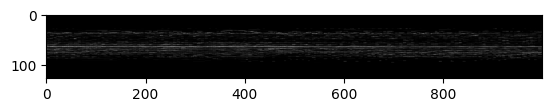

In [82]:
example = vae.predict(loaded_piano_rolls)
plt.imshow(np.transpose(example[0]), cmap='gray')

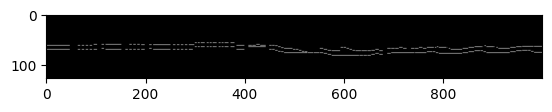

In [14]:
plt.imshow(np.transpose(loaded_piano_rolls[0]), cmap='gray')

1/1 [==============================] - 0s 43ms/step


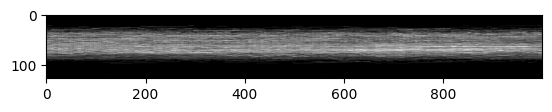

In [83]:
latent_vector = np.random.normal(size=(5, latent_dim))

# Сгенерировать новые данные с помощью декодера
# array = [[0] * 128 for i in range(5)]
generated_data = decoder.predict(latent_vector)

# for matrix in generated_data:
#     for i in range(len(matrix)):
#         for j in range(len(matrix[i])):
#             if matrix[i][j] < 0.45:
#                 matrix[i][j] = 0

# import matplotlib.pyplot as plt

plt.imshow(np.transpose(generated_data[0]), cmap='gray')
plt.show()

In [12]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\evges\AppData\Local\Temp\pip-install-w6xvw9lv\tensorflow-gpu_7b962e25d2524112b36e6032fe9f7804\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-e

In [64]:
np.save('generated/piano_rolls/classical/piano_rolls.npy', generated_data)